In [1]:
!kaggle datasets download paultimothymooney/blood-cells

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# White Blood Cell Segmentation — K-Means vs Fuzzy C-Means
# Dataset : Kaggle — Blood Cell Images (paultimothymooney/blood-cells)

import os, glob, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, measure, segmentation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, precision_score, recall_score, f1_score
import skfuzzy as fuzz
import cv2
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Unzip dataset into blood-cells folder
ZIP_FILE = "blood-cells.zip"
EXTRACT_DIR = "blood-cells"

if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_FILE, 'r') as z:
        z.extractall(EXTRACT_DIR)
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")

# show top-level structure
for root, dirs, files in os.walk(EXTRACT_DIR):
    depth = root.replace(EXTRACT_DIR, '').count(os.sep)
    if depth < 3:
        indent = ' ' * 2 * depth
        print(f"{indent}{os.path.basename(root)}/  ({len(files)} files)")
    if depth >= 3:
        break

Dataset already extracted.
blood-cells/  (0 files)
  dataset-master/  (0 files)
    dataset-master/  (1 files)


In [4]:
# Load blood cell images (use dataset2-master which has cleaner images)
possible_paths = [
    os.path.join(EXTRACT_DIR, "dataset2-master", "dataset2-master", "images", "TRAIN"),
    os.path.join(EXTRACT_DIR, "dataset2-master", "images", "TRAIN"),
    os.path.join(EXTRACT_DIR, "images", "TRAIN"),
]

IMG_DIR = None
for p in possible_paths:
    if os.path.exists(p):
        IMG_DIR = p
        break

# fallback: find any folder with JPEG images
if IMG_DIR is None:
    for root, dirs, files in os.walk(EXTRACT_DIR):
        jpgs = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if len(jpgs) > 50:
            IMG_DIR = root
            break

print(f"Image directory: {IMG_DIR}")

# collect all image paths across cell type subfolders
all_images = sorted(glob.glob(os.path.join(IMG_DIR, "**", "*.jpeg"), recursive=True) +
                    glob.glob(os.path.join(IMG_DIR, "**", "*.jpg"), recursive=True) +
                    glob.glob(os.path.join(IMG_DIR, "**", "*.png"), recursive=True))
print(f"Total images found: {len(all_images)}")

# sample a manageable subset for analysis (100 images, evenly spread)
np.random.seed(42)
sample_indices = np.random.choice(len(all_images), size=min(100, len(all_images)), replace=False)
sample_images = [all_images[i] for i in sorted(sample_indices)]
print(f"Sampled {len(sample_images)} images for analysis")

Image directory: blood-cells\dataset2-master\dataset2-master\images\TRAIN


Total images found: 9957
Sampled 100 images for analysis


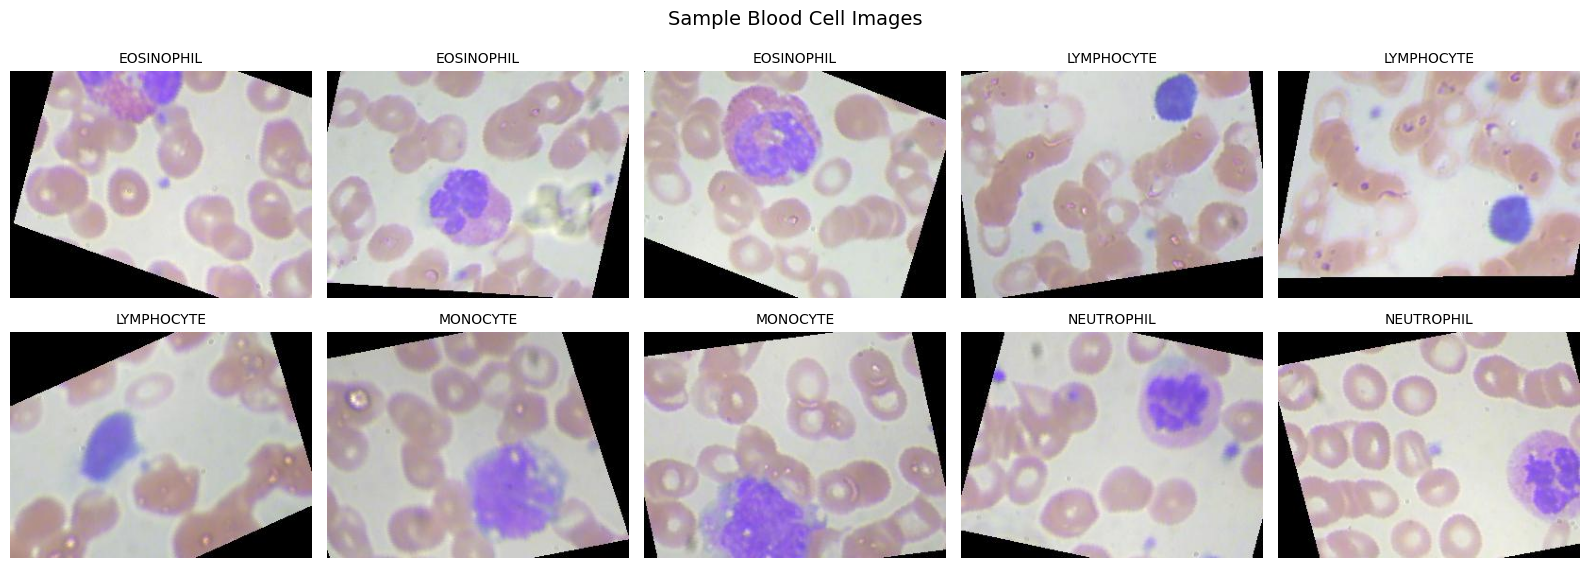

In [5]:
# Visualize sample blood cell images
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i, ax in enumerate(axes.flat):
    img = io.imread(sample_images[i * 10])
    ax.imshow(img)
    cell_type = os.path.basename(os.path.dirname(sample_images[i * 10]))
    ax.set_title(cell_type, fontsize=10)
    ax.axis("off")
plt.suptitle("Sample Blood Cell Images", fontsize=14)
plt.tight_layout()
plt.show()

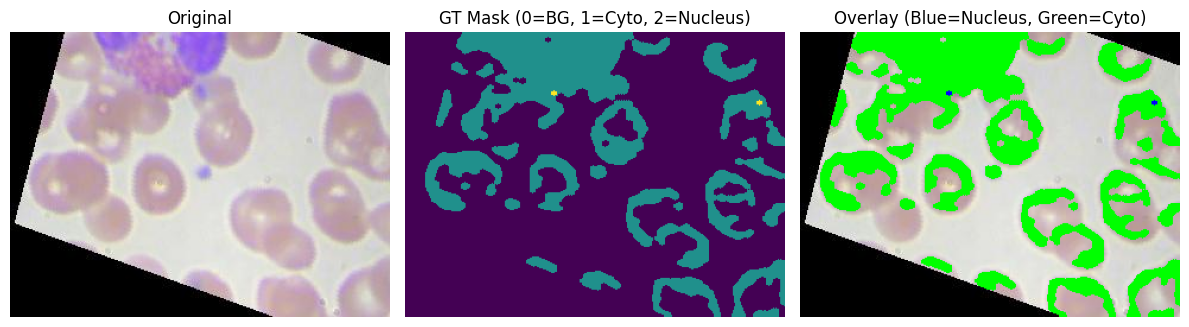

In [6]:
# Generate ground-truth masks using HSV color thresholding
# WBC nucleus = dark purple/blue, cytoplasm = lighter pink/blue, RBC/background = red/white
# We create a 3-class ground truth: background(0), cytoplasm(1), nucleus(2)

def create_gt_mask(img):
    """Create ground-truth WBC mask using HSV color thresholding"""
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # nucleus: dark purple/blue regions (high saturation, low-mid value)
    nucleus_mask = cv2.inRange(hsv, (120, 40, 20), (170, 255, 180))
    
    # cytoplasm: lighter purple/pink (lower saturation or higher value)
    cyto_mask = cv2.inRange(hsv, (100, 20, 80), (170, 255, 255))
    cyto_mask = cv2.bitwise_and(cyto_mask, cv2.bitwise_not(nucleus_mask))
    
    # morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    nucleus_mask = cv2.morphologyEx(nucleus_mask, cv2.MORPH_CLOSE, kernel)
    nucleus_mask = cv2.morphologyEx(nucleus_mask, cv2.MORPH_OPEN, kernel)
    cyto_mask = cv2.morphologyEx(cyto_mask, cv2.MORPH_CLOSE, kernel)
    cyto_mask = cv2.morphologyEx(cyto_mask, cv2.MORPH_OPEN, kernel)
    
    # combine: 0=background, 1=cytoplasm, 2=nucleus
    gt = np.zeros(img.shape[:2], dtype=np.uint8)
    gt[cyto_mask > 0] = 1
    gt[nucleus_mask > 0] = 2
    return gt

# test on one image
test_img = io.imread(sample_images[0])
test_gt = create_gt_mask(test_img)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(test_img)
axes[0].set_title("Original")
axes[1].imshow(test_gt, cmap="viridis")
axes[1].set_title("GT Mask (0=BG, 1=Cyto, 2=Nucleus)")
# overlay
overlay = test_img.copy()
overlay[test_gt == 2] = [0, 0, 255]   # nucleus in blue
overlay[test_gt == 1] = [0, 255, 0]   # cytoplasm in green
axes[2].imshow(overlay)
axes[2].set_title("Overlay (Blue=Nucleus, Green=Cyto)")
for ax in axes: ax.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# K-Means Segmentation (Hard Clustering)
# Uses sklearn.cluster.KMeans — each pixel assigned to exactly one cluster

def segment_kmeans(img, n_clusters=3):
    """Segment image using K-Means clustering in LAB color space"""
    # convert to LAB for perceptual uniformity
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float32)
    pixels = lab.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = kmeans.fit_predict(pixels)
    
    return labels.reshape(img.shape[:2]), kmeans

def segment_fcm(img, n_clusters=3, m=2, error=0.005, maxiter=100):
    """Segment image using Fuzzy C-Means clustering in LAB color space"""
    # convert to LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float32)
    pixels = lab.reshape(-1, 3).T  # skfuzzy expects (features, samples)
    
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels, c=n_clusters, m=m, error=error, maxiter=maxiter, seed=42
    )
    
    # hard labels from max membership
    labels = np.argmax(u, axis=0)
    return labels.reshape(img.shape[:2]), u, cntr

In [8]:
# Map cluster labels to semantic classes (background=0, cytoplasm=1, nucleus=2)
# by matching cluster centroids to GT class mean intensities

def map_clusters_to_gt(img, cluster_labels, gt_mask, n_clusters=3):
    """Map cluster IDs to GT classes using LAB centroid matching"""
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float32)
    
    # compute mean LAB for each GT class
    gt_means = []
    for c in range(n_clusters):
        mask = gt_mask == c
        if mask.sum() > 0:
            gt_means.append(lab[mask].mean(axis=0))
        else:
            gt_means.append(np.array([0, 0, 0]))
    
    # compute mean LAB for each cluster
    cl_means = []
    for c in range(n_clusters):
        mask = cluster_labels == c
        if mask.sum() > 0:
            cl_means.append(lab[mask].mean(axis=0))
        else:
            cl_means.append(np.array([0, 0, 0]))
    
    # find best mapping: assign each cluster to nearest GT class
    from scipy.spatial.distance import cdist
    dist = cdist(cl_means, gt_means, metric='euclidean')
    
    # greedy assignment
    mapped = np.zeros_like(cluster_labels)
    used_gt = set()
    used_cl = set()
    for _ in range(n_clusters):
        # find minimum distance pair not yet used
        min_val = np.inf
        best_cl, best_gt = 0, 0
        for ci in range(n_clusters):
            for gi in range(n_clusters):
                if ci not in used_cl and gi not in used_gt and dist[ci, gi] < min_val:
                    min_val = dist[ci, gi]
                    best_cl, best_gt = ci, gi
        mapped[cluster_labels == best_cl] = best_gt
        used_cl.add(best_cl)
        used_gt.add(best_gt)
    
    return mapped

In [9]:
# Boundary Extraction and Accuracy Metrics 

def extract_boundary(mask):
    """Extract boundary pixels using morphological gradient (cv2)"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=1)
    eroded = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
    return (dilated - eroded > 0).astype(np.uint8)

def boundary_metrics(pred_mask, gt_mask):
    """Compute boundary precision, recall, F1 with tolerance of 2px"""
    pred_boundary = extract_boundary(pred_mask)
    gt_boundary = extract_boundary(gt_mask)
    
    # dilate boundaries by 2px for tolerance
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    gt_dilated = cv2.dilate(gt_boundary, kernel, iterations=1)
    pred_dilated = cv2.dilate(pred_boundary, kernel, iterations=1)
    
    # precision: predicted boundary pixels that fall near GT boundary
    if pred_boundary.sum() > 0:
        prec = (pred_boundary & gt_dilated).sum() / pred_boundary.sum()
    else:
        prec = 1.0
    
    # recall: GT boundary pixels found near predicted boundary
    if gt_boundary.sum() > 0:
        rec = (gt_boundary & pred_dilated).sum() / gt_boundary.sum()
    else:
        rec = 1.0
    
    # F1
    if prec + rec > 0:
        f1 = 2 * prec * rec / (prec + rec)
    else:
        f1 = 0.0
    
    return prec, rec, f1

In [10]:
# Run K-Means and FCM on all sampled images and collect metrics
km_prec, km_rec, km_f1, km_sil = [], [], [], []
fcm_prec, fcm_rec, fcm_f1, fcm_sil = [], [], [], []

N_CLUSTERS = 3

for i, img_path in enumerate(sample_images):
    img = io.imread(img_path)
    if img.shape[2] == 4:  # RGBA -> RGB
        img = img[:, :, :3]
    
    gt = create_gt_mask(img)
    lab_pixels = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float32).reshape(-1, 3)
    
    # K-Means
    km_labels, km_model = segment_kmeans(img, N_CLUSTERS)
    km_mapped = map_clusters_to_gt(img, km_labels, gt, N_CLUSTERS)
    p, r, f = boundary_metrics(km_mapped, gt)
    km_prec.append(p); km_rec.append(r); km_f1.append(f)
    km_sil.append(silhouette_score(lab_pixels[::10], km_labels.flatten()[::10]))
    
    # FCM
    fcm_labels, fcm_u, fcm_cntr = segment_fcm(img, N_CLUSTERS)
    fcm_mapped = map_clusters_to_gt(img, fcm_labels, gt, N_CLUSTERS)
    p, r, f = boundary_metrics(fcm_mapped, gt)
    fcm_prec.append(p); fcm_rec.append(r); fcm_f1.append(f)
    fcm_sil.append(silhouette_score(lab_pixels[::10], fcm_labels.flatten()[::10]))
    
    if (i + 1) % 25 == 0:
        print(f"  Processed {i + 1}/{len(sample_images)} images...")

print(f"Done. Evaluated {len(sample_images)} images.")

  Processed 25/100 images...


  Processed 50/100 images...


  Processed 75/100 images...


  Processed 100/100 images...
Done. Evaluated 100 images.


In [11]:
# Summary table of results
results = pd.DataFrame({
    "Method": ["K-Means (Hard)", "FCM (Soft)"],
    "Boundary Precision": [np.mean(km_prec), np.mean(fcm_prec)],
    "Boundary Recall": [np.mean(km_rec), np.mean(fcm_rec)],
    "Boundary F1": [np.mean(km_f1), np.mean(fcm_f1)],
    "Silhouette Score": [np.mean(km_sil), np.mean(fcm_sil)],
})
results

,Method,Boundary Precision,Boundary Recall,Boundary F1,Silhouette Score
0,K-Means (Hard),0.448032,0.530080,0.468084,0.661457
1,FCM (Soft),0.468482,0.568048,0.499171,0.649154


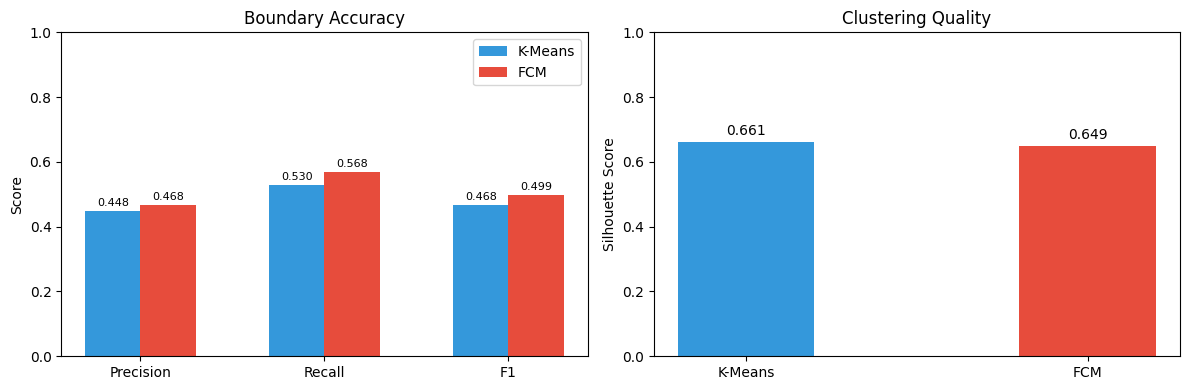

In [12]:
# Bar chart — Boundary F1 and Silhouette Score comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boundary metrics
metrics = ["Precision", "Recall", "F1"]
km_vals = [np.mean(km_prec), np.mean(km_rec), np.mean(km_f1)]
fcm_vals = [np.mean(fcm_prec), np.mean(fcm_rec), np.mean(fcm_f1)]
x = np.arange(len(metrics))
w = 0.3
b1 = axes[0].bar(x - w/2, km_vals, w, label="K-Means", color="#3498db")
b2 = axes[0].bar(x + w/2, fcm_vals, w, label="FCM", color="#e74c3c")
axes[0].set_xticks(x); axes[0].set_xticklabels(metrics)
axes[0].set_ylabel("Score"); axes[0].set_title("Boundary Accuracy")
axes[0].set_ylim(0, 1); axes[0].legend()
axes[0].bar_label(b1, fmt="%.3f", padding=2, fontsize=8)
axes[0].bar_label(b2, fmt="%.3f", padding=2, fontsize=8)

# Silhouette
methods = ["K-Means", "FCM"]
sil_vals = [np.mean(km_sil), np.mean(fcm_sil)]
bars = axes[1].bar(methods, sil_vals, color=["#3498db", "#e74c3c"], width=0.4)
axes[1].set_ylabel("Silhouette Score"); axes[1].set_title("Clustering Quality")
axes[1].set_ylim(0, 1)
axes[1].bar_label(bars, fmt="%.3f", padding=3)

plt.tight_layout()
plt.show()

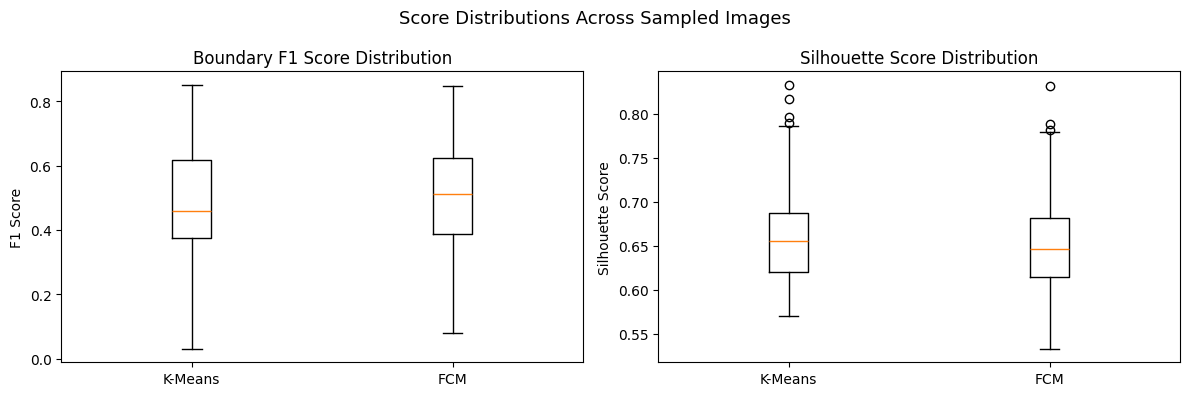

In [13]:
# Box plot — distribution of Boundary F1 scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].boxplot([km_f1, fcm_f1], labels=["K-Means", "FCM"])
axes[0].set_title("Boundary F1 Score Distribution")
axes[0].set_ylabel("F1 Score")

axes[1].boxplot([km_sil, fcm_sil], labels=["K-Means", "FCM"])
axes[1].set_title("Silhouette Score Distribution")
axes[1].set_ylabel("Silhouette Score")

plt.suptitle("Score Distributions Across Sampled Images", fontsize=13)
plt.tight_layout()
plt.show()

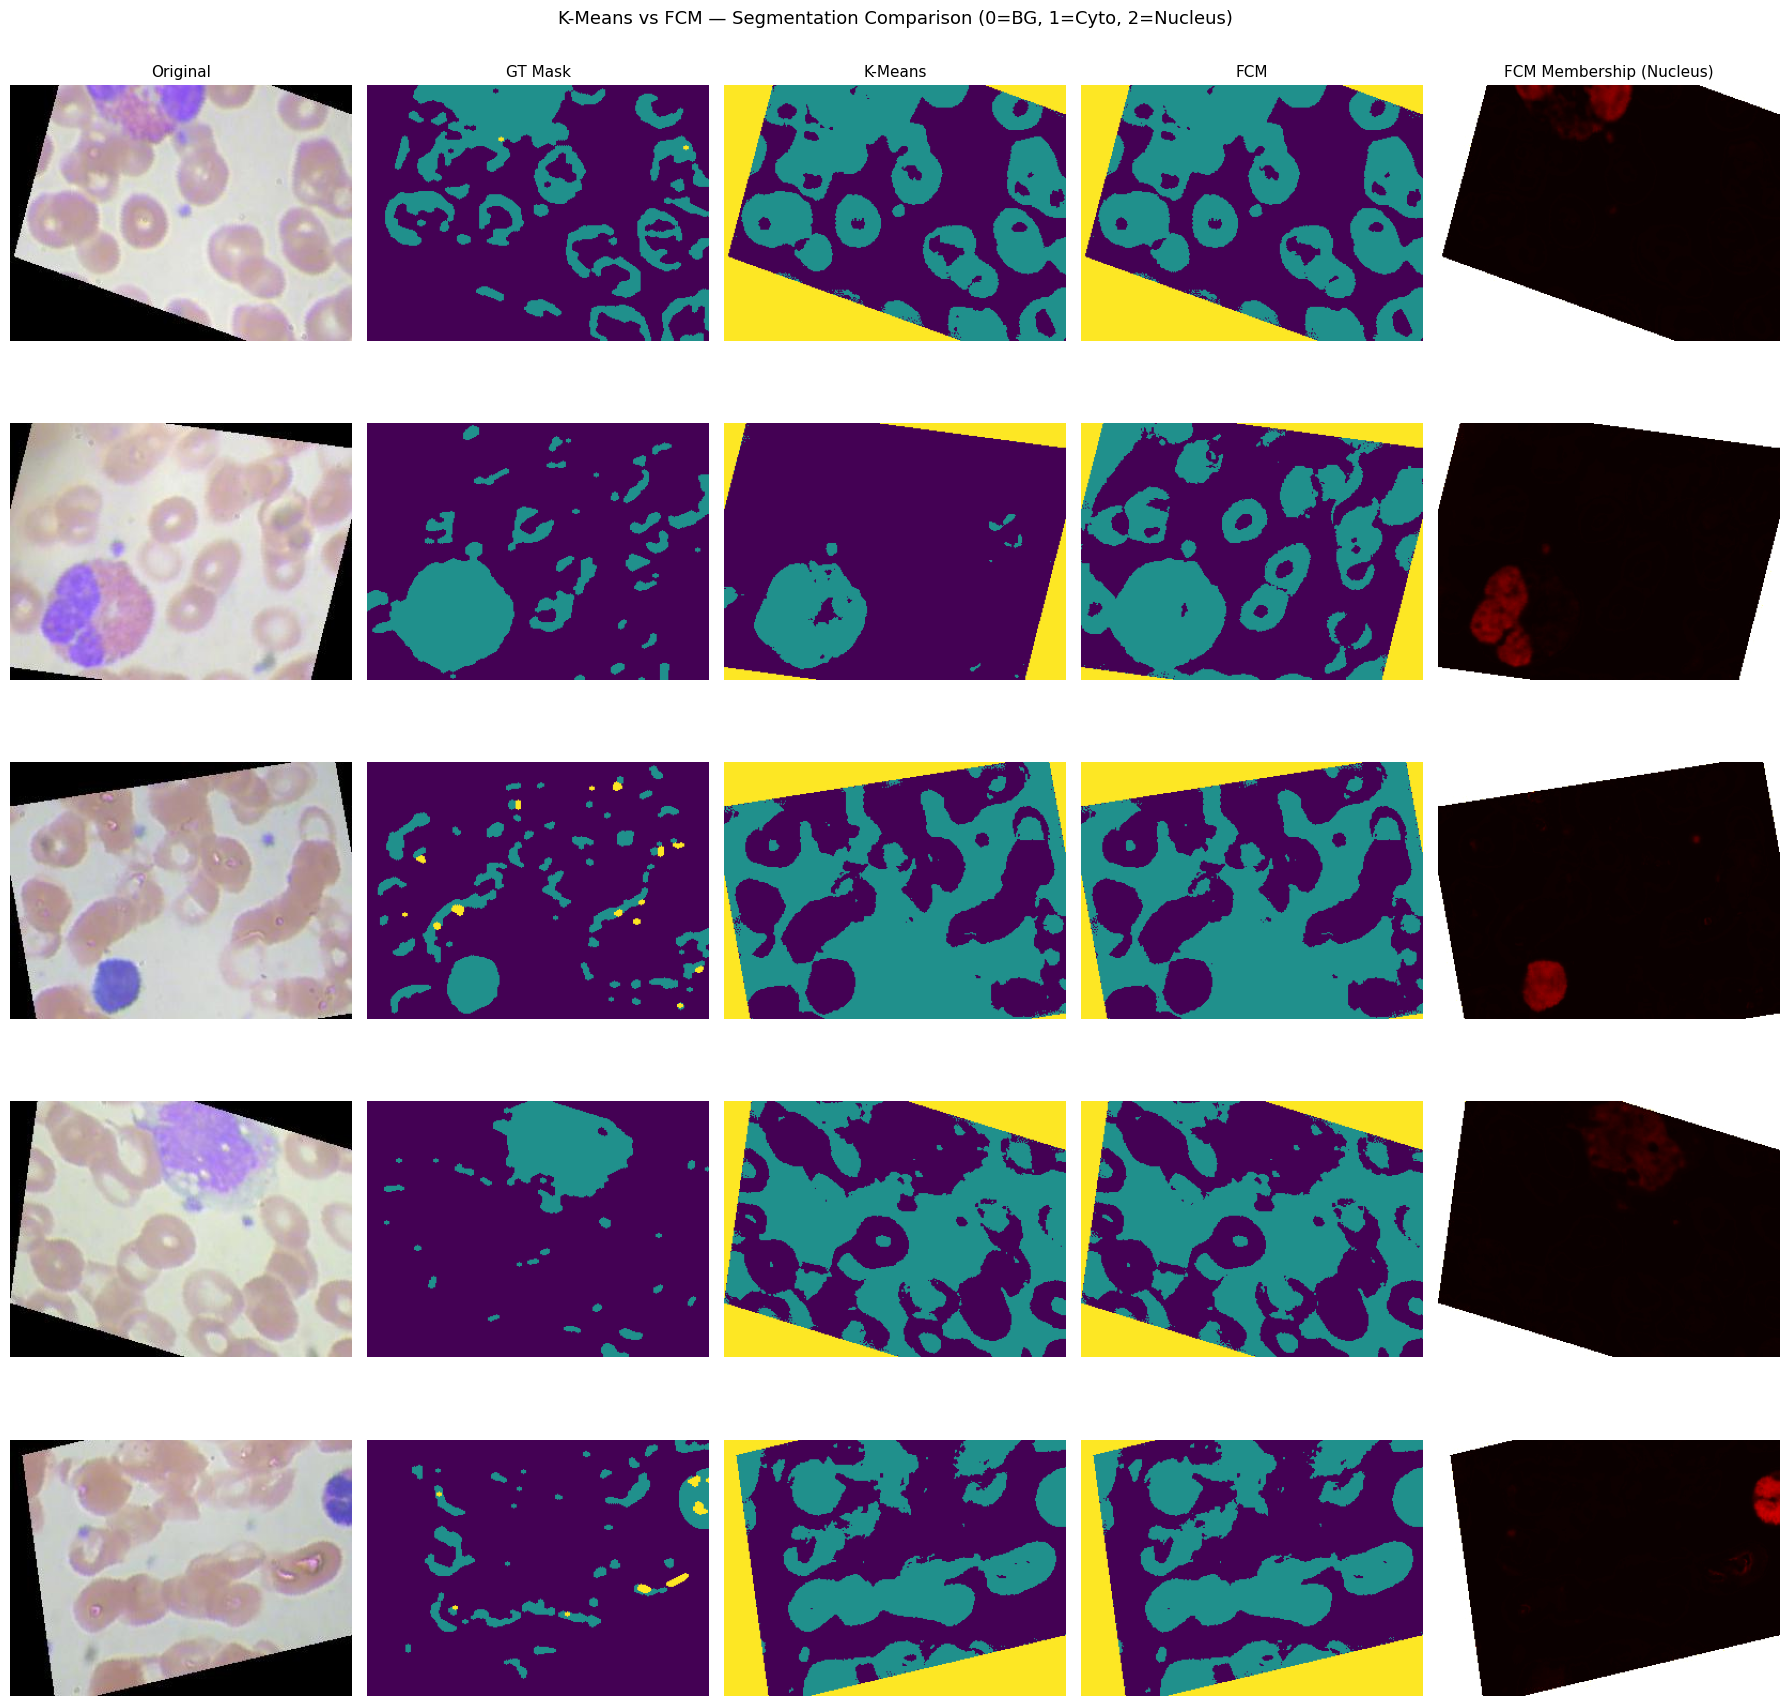

In [14]:
# Visual comparison — 5 sample images
fig, axes = plt.subplots(5, 5, figsize=(18, 18))
col_titles = ["Original", "GT Mask", "K-Means", "FCM", "FCM Membership (Nucleus)"]
vis_indices = np.linspace(0, len(sample_images) - 1, 5, dtype=int)

for row, idx in enumerate(vis_indices):
    img = io.imread(sample_images[idx])
    if img.shape[2] == 4: img = img[:, :, :3]
    gt = create_gt_mask(img)

    km_labels, _ = segment_kmeans(img, N_CLUSTERS)
    km_mapped = map_clusters_to_gt(img, km_labels, gt, N_CLUSTERS)

    fcm_labels, fcm_u, _ = segment_fcm(img, N_CLUSTERS)
    fcm_mapped = map_clusters_to_gt(img, fcm_labels, gt, N_CLUSTERS)

    axes[row, 0].imshow(img)
    axes[row, 1].imshow(gt, cmap="viridis", vmin=0, vmax=2)
    axes[row, 2].imshow(km_mapped, cmap="viridis", vmin=0, vmax=2)
    axes[row, 3].imshow(fcm_mapped, cmap="viridis", vmin=0, vmax=2)

    # show FCM soft membership for the nucleus cluster
    # select cluster with HIGHEST overlap with the mapped nucleus class (class 2)
    best_overlap = 0
    nucleus_fcm_cluster = 0
    for c in range(N_CLUSTERS):
        overlap = ((fcm_labels == c) & (fcm_mapped == 2)).sum()
        if overlap > best_overlap:
            best_overlap = overlap
            nucleus_fcm_cluster = c
    membership = fcm_u[nucleus_fcm_cluster].reshape(img.shape[:2])
    axes[row, 4].imshow(membership, cmap="hot")

    # boundary F1 labels
    _, _, f_km = boundary_metrics(km_mapped, gt)
    _, _, f_fcm = boundary_metrics(fcm_mapped, gt)
    axes[row, 0].set_ylabel(f"F1: KM={f_km:.2f} FCM={f_fcm:.2f}", fontsize=9)

for j, t in enumerate(col_titles):
    axes[0, j].set_title(t, fontsize=11)
for ax in axes.flat:
    ax.axis("off")
plt.suptitle("K-Means vs FCM — Segmentation Comparison (0=BG, 1=Cyto, 2=Nucleus)", fontsize=13)
plt.tight_layout()
plt.show()

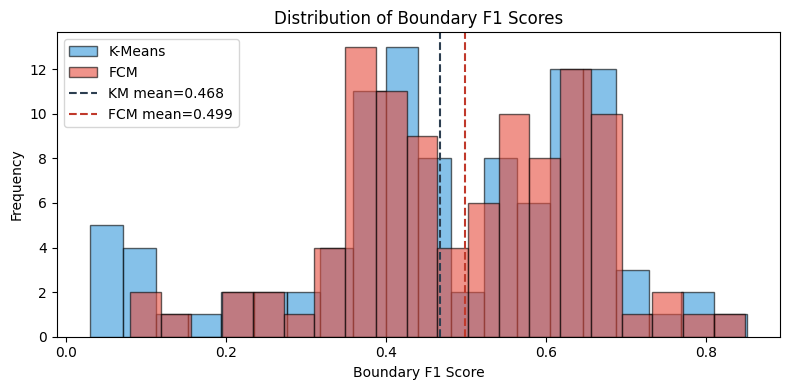

In [15]:
# Histogram of Boundary F1 scores
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(km_f1, bins=20, alpha=0.6, label="K-Means", color="#3498db", edgecolor="black")
ax.hist(fcm_f1, bins=20, alpha=0.6, label="FCM", color="#e74c3c", edgecolor="black")
ax.axvline(np.mean(km_f1), color="#2c3e50", linestyle="--", label=f"KM mean={np.mean(km_f1):.3f}")
ax.axvline(np.mean(fcm_f1), color="#c0392b", linestyle="--", label=f"FCM mean={np.mean(fcm_f1):.3f}")
ax.set_xlabel("Boundary F1 Score")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Boundary F1 Scores")
ax.legend()
plt.tight_layout()
plt.show()

In [16]:
# Conclusion
print("CONCLUSION: K-Means vs FCM for WBC Segmentation")
print()
print(f"  K-Means (Hard)  — Boundary F1: {np.mean(km_f1):.4f} ± {np.std(km_f1):.4f}  |  Silhouette: {np.mean(km_sil):.4f}")
print(f"  FCM     (Soft)  — Boundary F1: {np.mean(fcm_f1):.4f} ± {np.std(fcm_f1):.4f}  |  Silhouette: {np.mean(fcm_sil):.4f}")
print()
print("Boundary Accuracy (primary comparison):")
print(f"  - FCM achieves higher Boundary F1 ({np.mean(fcm_f1):.4f}) vs K-Means ({np.mean(km_f1):.4f})")
print(f"  - FCM also wins on Precision ({np.mean(fcm_prec):.4f} vs {np.mean(km_prec):.4f})")
print(f"    and Recall ({np.mean(fcm_rec):.4f} vs {np.mean(km_rec):.4f})")
print(f"  - Soft membership allows boundary pixels to partially belong to two classes,")
print(f"    reducing hard-assignment errors at ambiguous nucleus-cytoplasm borders.")
print()
print("Silhouette Score (cluster compactness insight):")
print(f"  - K-Means has a HIGHER silhouette ({np.mean(km_sil):.4f}) than FCM ({np.mean(fcm_sil):.4f})")
print(f"  - Silhouette measures cluster separation/compactness in LAB space.")
print(f"  - K-Means creates tighter, better-separated clusters (higher silhouette)")
print(f"    but its hard boundaries cause more misclassification at ambiguous pixels.")
print(f"  - FCM's softer cluster boundaries reduce compactness but capture biological")
print(f"    gradient transitions between nucleus, cytoplasm, and background.")
print()
print("Hard vs Soft Clustering — Key Insight:")
print("  - K-Means: every pixel assigned to exactly ONE cluster → sharp, sometimes wrong boundaries")
print("  - FCM: every pixel has a probability for EACH cluster → smooth, biologically realistic boundaries")
print("  - In the FCM membership heatmap, nucleus centers have high membership (bright),")
print("    while boundary pixels have intermediate values — capturing the soft transition")
print("    that K-Means cannot represent.")

CONCLUSION: K-Means vs FCM for WBC Segmentation

  K-Means (Hard)  — Boundary F1: 0.4681 ± 0.1891  |  Silhouette: 0.6615
  FCM     (Soft)  — Boundary F1: 0.4992 ± 0.1508  |  Silhouette: 0.6492

Boundary Accuracy (primary comparison):
  - FCM achieves higher Boundary F1 (0.4992) vs K-Means (0.4681)
  - FCM also wins on Precision (0.4685 vs 0.4480)
    and Recall (0.5680 vs 0.5301)
  - Soft membership allows boundary pixels to partially belong to two classes,
    reducing hard-assignment errors at ambiguous nucleus-cytoplasm borders.

Silhouette Score (cluster compactness insight):
  - K-Means has a HIGHER silhouette (0.6615) than FCM (0.6492)
  - Silhouette measures cluster separation/compactness in LAB space.
  - K-Means creates tighter, better-separated clusters (higher silhouette)
    but its hard boundaries cause more misclassification at ambiguous pixels.
  - FCM's softer cluster boundaries reduce compactness but capture biological
    gradient transitions between nucleus, cytoplas